# Step 1: 检视源数据集

In [1]:
import numpy as np

In [2]:
import pandas as pd

读入数据
一般来说源数据的index那一栏没什么用，我们可以用来作为我们pandas dataframe的index。这样之后要是检索起来也省事儿。<br>
有人的地方就有鄙视链。跟知乎一样。Kaggle的也是个处处呵呵的危险地带。Kaggle上默认把数据放在input文件夹下。所以我们没事儿写个教程什么的，也可以依据这个convention来，显得自己很有逼格。

In [3]:
train_df=pd.read_csv('./input/train.csv', index_col=0)
test_df=pd.read_csv('./input/test.csv',index_col=0)

../ 是父路径, ./是子路径

**检视源数据**

In [4]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


.head() 是前五行

# Step 2: 合并数据

这么做主要是为了用DF进行数据预处理的时候更加方便。等所有的需要的预处理进行完之后，我们再把他们分隔开。<br>
首先，SalePrice作为我们的训练目标，只会出现在训练集中，不会在测试集中(要不然你测试什么?)。所以，我们先把SalePrice这一列这给拿出来，不让它碍事儿。

我们先看一下SalePrice长什么样子

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price+1)'}>]], dtype=object)

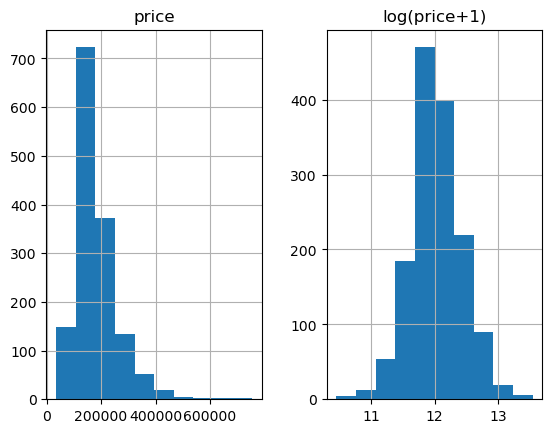

In [5]:
%matplotlib inline
prices=pd.DataFrame({"price":train_df["SalePrice"],"log(price+1)":np.log1p(train_df["SalePrice"])})
prices.hist()

可见，label本身并不平滑。为了我们分类器的学习更加准确，我们会首先把label给“平滑化”(正态化)<br>
这一步大部分同学会miss掉，导致自己的结果总是达不到一定标准。<br>
这里我们使用最有逼格的log1p,也就是log(x+1)，避免了复值的问题。<br>
记住哟，如果我们这里把数据都给平滑化了，那么最后算结果的时候，要记得把预测到的平滑数据给变回去。

按照“怎么来的怎么去”原则，log1p()就需要expm1();同理，lig就需要exp(), ...etx.

In [6]:
y_train=np.log1p(train_df.pop('SalePrice'))
y_train.head()

Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64

然后我们把剩下的部分合并起来

In [7]:
all_df=pd.concat((train_df,test_df),axis=0)

此刻，我们可以看到all_df就是我们合在一起的DF

In [8]:
all_df.shape

(2919, 79)

# Step 3: 变量转化

类似「特征工程」。就是把不方便处理或者不unify的数据给统一了。<br>
正确化变量属性<br>
首先，我们注意到，MSSubClass的值其实应该是一个category,但是Pandas是不会懂这些事儿的。使用DF的时候，这类数字符号会被默认记成数字。<br>
这种东西就很有误导性，我们需要把它变回成string

In [9]:
all_df['MSSubClass'].dtypes

dtype('int64')

In [10]:
all_df['MSSubClass']=all_df['MSSubClass'].astype(str)

变成str以后，做个统计，就很清楚了

In [11]:
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

dtype: int64  指的是后面这一列的数据格式

把category的变量转变成numerical表达形式<br>
当我们用numerical来表达categorical的时候，要注意，数字本身有大小的含义，所以乱用数字会给之后的模型学习带来麻烦。于是我们可以用One-Hot的方法来表达category。<br>
pandas自带的get dummies方法，可以帮你一键做到One-Hot。

In [12]:
pd.get_dummies(all_df['MSSubClass'],prefix='MSSubClass').head()

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


同理，我们把所有的category数据，都给One-Hot了

In [13]:
all_dummy_df=pd.get_dummies(all_df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


会自动选取可能的dummy

**处理好numerical变量**<br>
就算是numerical的变量，也还会有一些小问题<br>
比如，有一些数据是缺失的

In [14]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtFullBath      2
BsmtHalfBath      2
BsmtUnfSF         1
GarageArea        1
TotalBsmtSF       1
GarageCars        1
BsmtFinSF2        1
dtype: int64

.isnull(): 这是一个DataFrame的方法，用于检查DataFrame中的每个元素是否为缺失值（即NaN或None），并返回一个与原DataFrame形状相同的布尔型DataFrame，其中缺失值的位置为True，非缺失值的位置为False。<br>

.sum(): 这个方法用于对布尔型DataFrame进行求和操作，它将沿着指定的轴（默认为轴0，即列）对True的值进行计数。结果是一个Series对象，其中每个条目代表对应列或行中缺失值的数量。<br>

.sort_values(ascending=False): 这个方法用于对Series对象中的值进行排序。ascending=False参数表示降序排序，即缺失值数量最多的列或行排在前面。<br>

.head(): 这个方法用于返回排序后的Series对象的前n个条目，默认情况下n为5。在这个上下文中，它将返回缺失值数量最多的前5个列或行。<br>

处理这些缺失的信息，得靠好好审题。一般来说，数据集的描述里会写的很清楚，这些缺失都代表着什么。当然，如果实在没有的话，也只能靠自己的「想当然」。。
在这里，我们用平均值来填满这些空缺。

In [15]:
mean_cols=all_dummy_df.mean()
mean_cols.head(10)

LotFrontage        69.305795
LotArea         10168.114080
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea        102.201312
BsmtFinSF1        441.423235
BsmtFinSF2         49.582248
BsmtUnfSF         560.772104
dtype: float64

In [16]:
all_dummy_df=all_dummy_df.fillna(mean_cols)

看看是不是没有空缺了？

In [17]:
all_dummy_df.isnull().sum()

LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
YearBuilt                0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 303, dtype: int64

In [18]:
all_dummy_df.isnull().sum().sum()

0

**标准化numerical数据**<br>
这一步并不是必要，但是得看你想要用的分类器是什么。一般来说，regression的分类器都比较傲娇，最好是把源数据给放在一个标准分布内。不要让数据间的差距太大。<br>
这里，我们当然不需要把One-Hot的那些0/1数据给标准化。我们的目标应该是那些本来就是numerical的数据:<br>
先来看看哪些是numerical的:

In [19]:
numeric_cols=all_df.columns[all_df.dtypes !='object']
numeric_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

all_df.dtypes: 这是一个Series对象，其中包含all_df中每一列的数据类型。<br>

all_df.columns: 这是一个Index对象，包含all_df中所有列的名称。<br>

all_df.dtypes != 'object': 这是一个布尔索引，用于筛选出数据类型不是object（即不是对象类型，通常用于存储文本数据）的列。<br>

numeric_cols = all_df.columns[all_df.dtypes != 'object']: 这行代码的目的是创建一个名为numeric_cols的新变量，它是一个Index对象，包含了所有数据类型不是object的列的名称。换句话说，numeric_cols将包含所有数值型列的名称。

在pandas中，如果你想筛选特定数据类型的列，你可以使用与上面类似的方法，但会根据需要筛选的数据类型来调整条件。以下是一些筛选不同数据类型列的例子：<br>

筛选整数型列：<br>

integer_cols = all_df.columns[all_df.dtypes == 'int64'] <br>
筛选浮点型列：<br>

float_cols = all_df.columns[all_df.dtypes == 'float64'] <br>
筛选布尔型列：<br>

bool_cols = all_df.columns[all_df.dtypes == 'bool'] <br>
筛选日期时间型列（如果DataFrame中的日期时间列被识别为datetime64[ns]类型）：<br>

datetime_cols = all_df.columns[all_df.dtypes == 'datetime64[ns]'] <br>
筛选类别型列（如果DataFrame中的某些列被转换为pandas的Categorical类型）：<br>

category_cols = all_df.columns[all_df.dtypes == 'category'] <br>
筛选字符串型列（通常object类型用于存储字符串）：<br>

string_cols = all_df.columns[all_df.dtypes == 'object'] <br>
筛选所有非数值型列（除了整数和浮点数之外的所有类型）： <br>

non_numeric_cols = all_df.columns[~(all_df.dtypes == 'int64') & ~(all_df.dtypes == 'float64')] <br>
筛选特定数据类型的列（例如，筛选出所有object类型且实际内容为字符串的列）： <br>

object_string_cols = all_df.columns[(all_df.dtypes == 'object') & all_df.applymap(lambda x: isinstance(x, str))] <br>
请注意，具体的数据类型字符串（如'int64', 'float64', 'bool', 'datetime64[ns]', 'category', 'object'）可能会根据pandas的版本或具体数据而有所不同。在使用这些代码之前，建议先检查all_df.dtypes以确认数据类型。

计算标准分布:(X-X')/s <br>
让我们的数据点更平滑，更便于计算。<br>
注意:我们这里也是可以继续使用Log的，我只是给大家展示一下多种“使数据平滑”的办法。

In [20]:
numeric_col_means=all_dummy_df.loc[:, numeric_cols].mean()
numeric_col_std=all_dummy_df.loc[:,numeric_cols].std()
all_dummy_df.loc[:,numeric_cols]=(all_dummy_df.loc[:,numeric_cols]-numeric_col_means)/numeric_col_std

all_dummy_df.loc[:, numeric_cols]: 这是使用.loc属性进行列选择的一种方式。.loc用于基于标签的索引，其中第一个参数是行标签（在这里使用了:表示选择所有行），第二个参数是列标签（在这里是numeric_cols）。这将返回一个新的DataFrame，只包含numeric_cols中指定的列。

In [21]:
all_dummy_df.loc[:,numeric_cols].head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.202033,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.525112,0.580807,-0.29308,-0.934702,...,0.348840,-0.740634,0.199972,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,0.157619
2,0.501785,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.572152,1.177910,-0.29308,-0.629788,...,-0.059782,1.614603,-0.702722,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,-0.446848,-0.602858
3,-0.061269,0.137173,0.646073,-0.507197,0.980053,0.848819,0.334770,0.097856,-0.29308,-0.288467,...,0.627446,-0.740634,-0.081195,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,1.026577,0.157619
4,-0.436639,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.572152,-0.494856,-0.29308,-0.047266,...,0.785323,-0.740634,-0.184783,3.874303,-0.103313,-0.285886,-0.063139,-0.089577,-1.551918,-1.363335
5,0.689469,0.518814,1.355319,-0.507197,0.947040,0.753100,1.387248,0.468851,-0.29308,-0.161040,...,1.686149,0.776834,0.540332,-0.359539,-0.103313,-0.285886,-0.063139,-0.089577,2.131647,0.157619


# Step 4: 建立模型

把数据集分回 训练/测试集

In [22]:
train_df.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460],
           dtype='int64', name='Id', length=1460)

index: 这是pandas DataFrame的一个属性，它返回DataFrame的索引。索引在pandas中用于唯一标识每一行

In [23]:
dummy_train_df=all_dummy_df.loc[train_df.index]
dummy_test_df=all_dummy_df.loc[test_df.index]

In [24]:
dummy_train_df.shape, dummy_test_df.shape

((1460, 303), (1459, 303))

**Ridge Regression**

用Ridge Regression模型来跑一遍看看。（对于多因子的数据集，这种模型可以方便地把所有的var都无脑的放进去）

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

这一步不是很必要，只是把DF转换成Numby Array，这跟Sklearn更加陪

In [26]:
X_train=dummy_train_df.values
X_test=dummy_test_df.values

用Sklearn自带的cross validation方法来测试模型

通过交叉验证选择最好的模型

In [27]:
alphas=np.logspace(-3,2,50)
test_scores=[]
for alpha in alphas:
    clf=Ridge(alpha)
    test_score=np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

存下所有的CV值，看看哪个alpha值更好（也就是【调参数】）

这段代码使用了Python的NumPy库来创建一个对数等差数列的数组。下面是对代码的分析：<br>

alphas 是一个变量名，用来存储生成的数组。<br>
np 是NumPy库的常用缩写，表示需要先导入NumPy库才能使用这个变量。<br>
logspace 是NumPy库中的一个函数，用于生成在对数尺度上等差分布的数列。<br>
-3 和 2 是 logspace 函数的前两个参数，分别表示数列的起始和结束的对数值。这里，-3 对应于 10 的 -3 次方，即 0.001；2 对应于 10 的 2 次方，即 100。<br>
50 是 logspace 函数的第三个参数，表示生成的数列中元素的个数。<br>
综合来看，np.logspace(-3, 2, 50) 这行代码生成了一个包含50个元素的数组，数组中的数值从 10 的 -3 次方（0.001）开始，以 10 的 2 次方（100）结束，这些数值在对数尺度上是均匀分布的。

这段代码是用于评估机器学习模型性能的Python代码，使用了scikit-learn库。下面是对代码的分析：<br>

test_score 是一个变量名，用来存储计算得到的交叉验证分数。<br>
np.sqrt 是NumPy库中的函数，用于计算平方根。<br>
-cross_val_score 是scikit-learn库中的函数，用于计算交叉验证的分数。这里的负号表示我们实际上计算的是正的均方误差（MSE），因为cross_val_score函数默认返回的是损失函数的负值。<br>
clf 是一个模型实例，比如之前提到的Ridge回归模型。<br>
X_train 和 y_train 分别是训练数据的特征矩阵和目标变量数组。<br>
cv=10 表示使用10折交叉验证。这意味着数据将被分成10份，模型将被训练10次，每次使用其中的9份作为训练集，剩下的1份作为验证集。<br>
scoring='neg_mean_squared_error' 指定了交叉验证的评分标准是负均方误差。均方误差是回归问题中常用的损失函数，衡量模型预测值与实际值之间的差异。负均方误差在这里使用是因为scikit-learn的评分指标默认返回的是损失，而不是评分，所以使用负号来获取实际的均方误差值。<br>
综合来看，test_score=np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error')) 这行代码的作用是计算模型在10折交叉验证下的平均均方根误差（RMSE）。RMSE是评估回归模型性能的一个常用指标，它提供了预测误差的标准度量，并且由于平方根的作用，RMSE的单位与原始数据的单位相同，这使得结果更易于解释

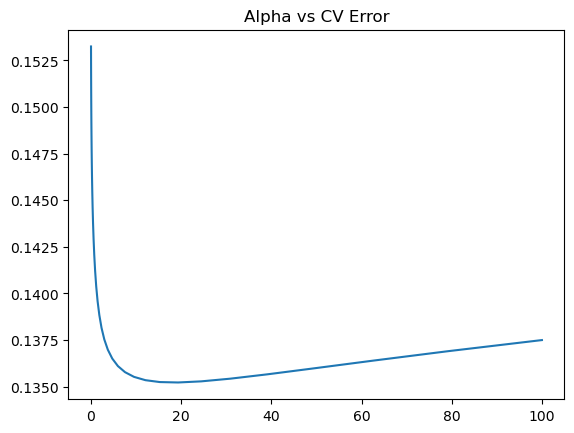

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(alphas, test_scores)
plt.title("Alpha vs CV Error");

可见，大概alpha=10-20的时候，可以把score达到0.135左右

In [31]:
print(test_scores)

[0.15324561838998632, 0.1532165901158276, 0.15318247486696523, 0.15314054463166124, 0.1530881214439977, 0.15302264371776927, 0.1529416577961254, 0.15284274797610836, 0.1527234190037256, 0.15258094800335262, 0.15241223179469252, 0.15221366732310168, 0.15198110993610506, 0.15170995056107256, 0.15139533822853815, 0.15103255217726136, 0.15061749914437708, 0.15014727399056874, 0.1496206769025678, 0.14903854361575947, 0.1484037479630363, 0.14772081094403483, 0.14699520088553114, 0.14623258268763456, 0.14543836722419584, 0.14461782776948323, 0.14377678461886403, 0.1429225409566, 0.14206457835916014, 0.14121461063621235, 0.1403858986107405, 0.13959205633497168, 0.13884574605016128, 0.13815761473374194, 0.1375356634813173, 0.13698509308138584, 0.1365085906052538, 0.13610697963662802, 0.13578010229636606, 0.135527735997103, 0.13535031944858839, 0.13524931203692245, 0.13522713236186945, 0.13528676507183723, 0.13543122886103734, 0.13566312495774507, 0.1359844382371972, 0.13639668144768505, 0.13690

In [32]:
print(alphas)

[1.00000000e-03 1.26485522e-03 1.59985872e-03 2.02358965e-03
 2.55954792e-03 3.23745754e-03 4.09491506e-03 5.17947468e-03
 6.55128557e-03 8.28642773e-03 1.04811313e-02 1.32571137e-02
 1.67683294e-02 2.12095089e-02 2.68269580e-02 3.39322177e-02
 4.29193426e-02 5.42867544e-02 6.86648845e-02 8.68511374e-02
 1.09854114e-01 1.38949549e-01 1.75751062e-01 2.22299648e-01
 2.81176870e-01 3.55648031e-01 4.49843267e-01 5.68986603e-01
 7.19685673e-01 9.10298178e-01 1.15139540e+00 1.45634848e+00
 1.84206997e+00 2.32995181e+00 2.94705170e+00 3.72759372e+00
 4.71486636e+00 5.96362332e+00 7.54312006e+00 9.54095476e+00
 1.20679264e+01 1.52641797e+01 1.93069773e+01 2.44205309e+01
 3.08884360e+01 3.90693994e+01 4.94171336e+01 6.25055193e+01
 7.90604321e+01 1.00000000e+02]


**Random Forest**

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
max_features=[.1,.3,.5,.7,.9,.99]
test_scores=[]
for max_feat in max_features:
    clf=RandomForestRegressor(n_estimators=200,max_features=max_feat)
    test_score=np.sqrt(-cross_val_score(clf,X_train,y_train,cv=5,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5, 1.0, 'Max Festures vs CV Error')

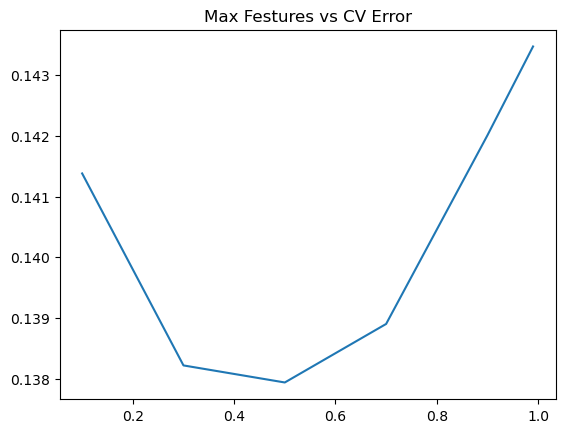

In [39]:
plt.plot(max_features,test_scores)
plt.title("Max Festures vs CV Error")

用RF的最优值达到了0.137

# Step 5: Ensemble

这里我们用一个Stacking的思维来汲取两种或者多种模型的优点

首先，我们把最好的parameter拿出来，做成我们最优的model

In [42]:
ridge=Ridge(alpha)
rf=RandomForestRegressor(n_estimators=500,max_features=0.5)

In [44]:
ridge.fit(X_train,y_train)
rf.fit(X_train,y_train)

RandomForestRegressor(max_features=0.5, n_estimators=500)

上面提到了，因为最前面我们给lable做了个log(1+x)，于是这里我们需要把predict的值给exp回去，并且减掉那个"1"

所以就是我们的expm1()函数 exp minus 1

In [50]:
y_ridge=np.expm1(ridge.predict(X_test))
y_rf=np.expm1(rf.predict(X_test))

一个正经的Ensemble就是把这群model的预测结果作为新的input，再做一次预测。这里我们简单的方法，就是直接【平均化】

就是再搞一次回归

In [51]:
y_final=(y_ridge+y_rf)/2

# Step 6：提交结果

In [54]:
submission_df=pd.DataFrame(data={'Id':test_df.index,'SalePrice':y_final})

我们的submission大概长这样

In [55]:
submission_df.head(10)

,Id,SalePrice
0,1461,119695.501120
1,1462,149366.741379
2,1463,174472.269665
3,1464,190696.485775
4,1465,192296.979350
5,1466,176449.696265
6,1467,177733.023904
7,1468,170294.915077
8,1469,183841.397267
9,1470,120939.048717
